# Abstract

I am acting as an NBA consultant; based on the 3-year performances of players before becoming Free Agents and the contract they ended up signing (calculated per year), I want to predict how this year's free agents will do (the 2018-19 season is only 1-2 games from being over). Teams targeting certain free agents in the Summer of '19 will be able to use this to determine who they want to target as their main pursuit. 

# Obtain the Data

First I will scrape data from basketball-reference.com that has player's individual statitstics per season from 2008-2009 to 2017-18 seasons. This will contain data with various player statistics that I can use as my features in the model. Also from basketball-reference.com I will collect rookie lists to make sure I don't have outliers since 3-year performances are being combined.

I will also scrape free agent lists from 2011 to 2018 seasons that will help me filter out non-impending free agents. This is available on spotrac.com.

Finally, I will collect salary information for players from 2008-2009 to 2017-2018 from HoopsHype.com. This data will help me collect the target variable information.


In [18]:
# %%writefile ../src/data/make_dataset.py

# imports
import pandas as pd
import time
from datetime import datetime
import os
import pickle

from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.common.by import By
from selenium.common.exceptions import NoSuchElementException       
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.select import Select

def check_exists(driver,classname):
    try:
        driver.find_element_by_class_name(classname)
    except NoSuchElementException:
        return False
    return True

def initialize_selenium(URL):
    # initialize selenium
    chromedriver = "/Applications/chromedriver" 
    os.environ["webdriver.chrome.driver"] = chromedriver
    driver = webdriver.Chrome(chromedriver)
    driver.get(URL)
    
    return driver  

# Generate dictionary to store our data per year
def data_to_dict(years):
    """
    Generate Dictionary that will store our data per year in this format:
    
    Key (Year): Value (Data)
    
    years: int indicating how many years of data will be stored
    """
    data = {}
    CURRENT_YEAR = int(datetime.now().year)
    years_label = range(CURRENT_YEAR-1,CURRENT_YEAR-years,-1)
    
    return years_label, data
    
def download_salary_data(URL,years):
    
    years_label, data = data_to_dict(years)
    driver = initialize_selenium(URL)
    print(list(years_label))

    for i in years_label:
        time.sleep(2)
        df = pd.read_html(driver.current_url)[0] 
        data[i]=df
        years = driver.find_element_by_class_name("salaries-team-selector-top")
        years.click()
        year = driver.find_element_by_link_text(str(i-1)+"/"+str(i-2000).zfill(2))
        year.click()
        
    driver.quit()
    
    return data

def download_rookie_data(URL, years):
    
    years_label, data = data_to_dict(years)
    driver = initialize_selenium(URL)
    wait = WebDriverWait(driver, 10)
    
    for i in years_label:
        df = pd.read_html(driver.current_url)[0]
        df.columns=df.columns.droplevel()
        df = df[['Player']]
        data[i]=df
        prev_year = driver.find_element_by_css_selector("a.button2.prev")
        prev_year.click()
        time.sleep(10)
    
    driver.quit()
    
    return data
    
    
def download_player_data(URL, years, type_data):
    
    years_label, data = data_to_dict(years)
    driver = initialize_selenium(URL)
    wait = WebDriverWait(driver, 10)
    
    # get to the current season stats, this may have changed
    tab = driver.find_elements_by_id("header_leagues")
    hover = ActionChains(driver).move_to_element(tab[0])
    hover.perform()
    wait.until(EC.visibility_of_element_located((By.LINK_TEXT, type_data))).click()
    
    for i in years_label:
        prev_year = driver.find_element_by_css_selector("a.button2.prev")
        prev_year.click()
        time.sleep(10)
        df = pd.read_html(driver.current_url)[0]
        df = df[df.Rk != 'Rk']
        data[i]=df
    
    driver.quit()
    
    return data

def download_fa_data(URL):
    data={}
    driver = initialize_selenium(URL)

    for i in range(2018,2010,-1):
        years = Select(driver.find_element_by_name('year'))
        years.select_by_visible_text(str(i))
        submit = driver.find_element_by_class_name('go')
        submit.click()
        time.sleep(10)
        df = pd.read_html(driver.current_url)[0]
        data[i]=df
    
    driver.quit()
    
    return data

def save_dataset(data,filename):
    with open(filename, 'wb') as w:
        pickle.dump(data,w)
        
def run():
    """
    Executes a set of helper functions that download data from one or more sources
    and saves those datasets to the data/raw directory.
    """
    data_fa = download_fa_data("https://www.spotrac.com/nba/free-agents/")
    data_reg = download_player_data("https://www.basketball-reference.com", 12, "Per G")
    data_adv = download_player_data("https://www.basketball-reference.com", 12, "Advanced")
    data_salary = download_salary_data("https://hoopshype.com/salaries/players/", 12)
    data_rookie = download_rookie_data("https://www.basketball-reference.com/leagues/NBA_2018_rookies.html", 12)
    save_dataset(data_fa, "data/raw/freeagents2.pickle")
    save_dataset(data_reg, "data/raw/regstats2.pickle")
    save_dataset(data_adv, "data/raw/advstats2.pickle")
    save_dataset(data_salary, "data/raw/salaries2.pickle")
    save_dataset(data_rookie, "data/raw/rookies2.pickle")

Overwriting ../src/data/make_dataset.py


In [19]:
# run()

# Scrub the Data

## Salary List Data

Here are the thing's that were fixed going through the Salary List Data:

1. Fix some headers (0 -> Rank, 1-> Name, 2-> Team, 3-> Salary)
2. Remove rows with those header labels, as they were repeated in the website tables
3. Add year column for when the lists are aggregated into a single dataframe

Then the lists were aggregated into a single salary dataframe. Afterwards, these were fixed:

1. Change Salary format (remove $ and commas)
2. Split position from the name into a new column
3. Change Salary datatype to int
4. Remove Rk column; it's not significant

## Player Stats Data

### Before Aggregation of Regular and Advanced Stats Year-wise

Some things I notice:

- Both: There are players who were traded mid-season that have appeared as rows of both teams, and a total season. I want to keep the cumulative total row (Tm assigned to TOT) and get rid of partial team stats.
- Both: It will be useful to again add a Year column for after I aggregate each lists into a single dataframe. This can be done after this step

After taking care of these, I combined regular stats and advanced stats for the same year into a single dataframe. Now the dataframes are by year (with both regular and advanced stats)

### Before Aggregation of Yearly stats into a single dataframe

Now we have combined stats for each type of stats. Some basic cleaning can be done before all years are combined into one giant dataframe:

1. Some columns can be eliminated (Two "unnamed" arbitrary empty columns were on the website when I scraped. Rk_x and Rk_y were arbitrary rankings done by alphabetic order and is insiginficant as well)
2. We can remove one of the MP (Minutes Played) columns; there was a conflict during dataframe merge because regular stats data compiled minutes played as per game average, whereas the Advance stats data compiled minutes played as season total. I will remove MP_y.
3. Add the year of the player stat here in a column called 'Year'.

After adding them all together, I changed some datatypes for better processing.

- Player, Position, Tm, Year -> unchanged
- Age, G, GS -> int
- Everything else -> floats

## Rookies list and using it to remove from player stats

Rookies have no previous year's stats (because they were in college or overseas), so we cannot use their data. Therefore we must identify the rookies for each year and remove them from the stats list.

There are some weird "Player" that shows up. Also some null values got picked up when it was scraped. We can remove those rows ("Player" is part of the table header that got repeated on Basketball Reference). We can also add a Year column that will be useful to identify which year the rookies belong (just like our other lists). After that we can concatenate the dataframes into a single one, and merge with the stats to remove them from the stats dataframe.

## Adding FA information

Now we want to filter out the data for all the FA's on our list, but before we do that, we must look at one thing: the way naming is done differently between the salaries list (from ESPN.com) and the stats list (from Basketball-Reference.com). I noticed two weird things:

1. Suffixes are missing (notably Jr.) in Basketball-Reference list
2. Also players that go by initials (i.e. J.J. Redick in Basketball-Reference) are missing periods in the other list (i.e. JJ Redick in ESPN).

### Some column conflicts happened on the merge:

- Tm: I will use Tm_x as that was from the salary data. It is the team that paid the player on the season following (2018 salary is for the 2018-19 season, while 2018 stats is for the 2017-18 season)
- Pos: I will also use Pos_x although position ambiguity is really on the data collector's hands; some players can be either guard position, or either forward position, or some could be SG/SF. There is no real definition on positions now, as NBA is becoming more positionless and a guard is able to do what forwards used to, and vice versa. Even some centers handle the ball like a guard!

## Missing Data after merging all the dataframes:

Here are the possibilities based on some research:

1. Some did not have stats because they were out of the NBA (not playing basketball entirely or overseas). These players should also be removed from the considerations.

2. Some players are missing a couple stats only (way to treat those datapoints will be explored in the next section).

After taking care of all of these, I pickle'd the dataframe and move onto the next section.

In [21]:
# %%writefile ../src/features/build_features.py

# imports
import re
import os
import pickle
import pandas as pd
import numpy as np
from functools import reduce

# Remove rookies from stats
def remove_rookies(stats, rookies):
    
    COLS = ['Player','Year']

    no_rookies = stats.merge(rookies, indicator=True, how='outer')
    no_rookies = no_rookies[no_rookies['_merge'] == 'left_only']
    del no_rookies['_merge']
    
    save_dataset(no_rookies,"../data/interim/norookiestats.pickle")
    
    return no_rookies

# Merge stats with salaries
def salary_merge(salaries, no_rookies):
    
    salaries['Player'] = salaries['Player'].map(lambda x: x.replace(' Jr.',""))
    no_rookies['Player'] = no_rookies['Player'].map(lambda x: x.replace('.',""))
    data_all = pd.merge(salaries,no_rookies, on=['Player','Year'], how='left')
    
    # Remove unnecessary columns that happened on merge conflict
#     data_all.rename(columns={'Tm_x': 'Tm','Pos_x':'Pos','MP_x':'MP'}, inplace=True)
    
    # Drop players that have too many missing stat information
    playerinfo =['Player','Tm','Salary','Year','Pos']
    rest = data_all.columns.difference(playerinfo)
    played = data_all.dropna(thresh=20)
    
    return played

# Merge the FA list into the stats list
def FA_merge(played, freeagents):
    
    FA_check = played.merge(freeagents, indicator=True, how='left')
    played["FA"] = FA_check["_merge"]
    played["FA"] = played["FA"].str.replace("left_only",'No').replace("both","Yes")
    played = played[~played['FA'].isnull()]
    
    # I chose to fill Null values with 0
    played = played.fillna(0)
    
    return played

# Accumulate stats of 3 past seasons and update the list with it
def accumulate_stats(played,stats):
    
    totallist=['MP', 'FG', 'FGA','3P', '3PA',  '2P', 
           '2PA', 'FT', 'FTA', 'ORB', 'DRB', 
           'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']
    
    for i in range(played.shape[0]):
        curr = played.iloc[i].Player
        curryear = played.iloc[i].Year
        years  = [curryear, curryear-1, curryear-2]
        threeyrs = stats[(stats.Player == curr) & (stats.Year.isin(years))]
        if threeyrs.shape[0] > 1:
            print("Update row "+str(i))
            for stat in totallist:
                played.iloc[i, played.columns.get_loc(stat)] = (reduce((lambda x, y: x + y), 
                                  [k*v for k,v in zip(threeyrs[stat],threeyrs.G)])) #/ threeyrs.G.sum()
            played.iloc[i, played.columns.get_loc('G')] = threeyrs.G.sum()#/len(threeyrs)
            played.iloc[i, played.columns.get_loc('GS')] = threeyrs.GS.sum()#/len(threeyrs)
    
    return played

# Clean salaries data
def clean_salaries_dataset(path, filename):
    money = pickle.load(open(path+"/"+filename, "rb"))
    combined={}
    
    for k,v in money.items():
        calendar = str(k)+"/"+str(k-1999).zfill(2)
        print(calendar)
        temp = v[['Player',calendar]]
        temp["Year"] = k
        temp = temp.rename(columns={calendar:"Salary"})
        combined[k]=temp
    
    salaries = reduce(lambda x,y:pd.concat([x,y]),[v for k,v in combined.items()])
    salaries["Salary"] = salaries["Salary"].str.replace('$','').str.replace(',','')
    salaries.Salary = salaries.Salary.astype(int)
    
    return salaries
    
# Clean stats (regular and advanced) data   
def clean_stats_dataset(path, filename1, filename2):
    stats = pickle.load(open(path+"/"+filename2, "rb"))
    advs = pickle.load(open(path+"/"+filename1, "rb"))
    
    for i,j in stats.items():
        temp = j 
        temp['total'] = (temp['Tm'] == 'TOT')
        temp = temp.sort_values('total', ascending=False).drop_duplicates(['Player','Age']).drop('total', 1)
        stats[i]=temp
        
    for i,j in advs.items():
        temp = j 
        temp['total'] = (temp['Tm'] == 'TOT')
        temp = temp.sort_values('total', ascending=False).drop_duplicates(['Player','Age']).drop('total', 1)
        advs[i]=temp
        
    combined={}
    for (a1,b1),(a2,b2) in zip(stats.items(),advs.items()):
        df = b1.merge(b2, how="inner",on=["Player","Age","Pos","Tm","G"])#,"MP"])
        combined[a1]=df.sort_values("Player")
        print("Stats Row for "+str(a1)+": "+str(b1.shape[0])
              +", Adv Row for "+str(a2)+": "+str(b2.shape[0])+", After combined: "+str(df.shape[0]))
    
    for k,v in combined.items():
        v=v.drop(['Rk_x','Unnamed: 19','Unnamed: 24', 'Rk_y','MP_y'], axis=1)
        v['Year'] = k
        combined[k]=v
    
    combined_stats = reduce(lambda x,y:pd.concat([x,y]),[v for k,v in combined.items() if k != 2019 or k != 2008])
    combined_stats = combined_stats.reset_index(drop=True);
    
    unchanged = ['Player','Pos','Tm','Year']
    intlist = ['Age','G','GS']
    floatlist= combined_stats.columns.difference(unchanged+intlist)
    
    combined_stats[intlist] = combined_stats[intlist].astype(int)
    combined_stats[floatlist] = combined_stats[floatlist].astype(float)
    combined_stats.rename(columns={'MP_x':'MP'}, inplace=True)
    
    return combined_stats

# Clean rookies data
def clean_rookies_dataset(path, filename):
    rookies = pickle.load(open(path+"/"+filename, "rb"))
    
    combined_rookies = pd.DataFrame()
    for v,k in rookies.items():
        temp = rookies[v][rookies[v].Player != 'Player']
        temp = temp[~(temp.Player.isnull())]
        temp['Year']=v
        combined_rookies = pd.concat([combined_rookies,temp])
    
    return combined_rookies

# Clean FA data
def clean_fa_dataset(path, filename):
    freeagents = pickle.load(open(path+"/"+filename, "rb"))
    FAS={}
    for k,v in freeagents.items():
        v.columns=[re.sub(r"Player.+","Player",col) for col in v.columns]
        v.columns=[re.sub(r"\d+ Cap Hit","Cap Hit",col) for col in v.columns]
        v["Year"] = k
        FAS[k]=v
    
    freeagents = reduce(lambda x,y:pd.concat([x,y]),[v for k,v in FAS.items() if k != 2019])
    freeagents = freeagents[['Player','Year']]
    
    return freeagents

# Build overall dataset
def build_dataset(salaries, stats, rookies, freeagents):
    
    no_rookies = remove_rookies(stats, rookies)
    
    played = salary_merge(salaries, no_rookies)
    
    players = FA_merge(played, freeagents)
    
    return accumulate_stats(players,stats)

# dump file to pickle
def save_features(data,filename):
    with open(filename,"wb") as writer:
        pickle.dump(data,writer)

def run():
    """
    Executes a set of helper functions that read files from data/raw, cleans them,
    and converts the data into a design matrix that is ready for modeling.
    """
    salaries = clean_salaries_dataset('data/raw', "salaries2.pickle")
    stats = clean_stats_dataset('data/raw', "advstats2.pickle", "regstats2.pickle")
    rookies = clean_rookies_dataset('data/raw','rookies2.pickle')
    freeagents = clean_fa_dataset('data/raw','freeagents2.pickle')
    
    save_dataset(salaries, "data/interim/salaries2.pickle")
    save_dataset(stats, "data/interim/stats2.pickle")
    save_dataset(rookies, "data/interim/rookies2.pickle")
    save_dataset(freeagents, "data/interim/fa2.pickle")
    
    full_data = build_dataset(salaries, stats, rookies, freeagents)
    
    save_features(full_data,'data/processed/data2.pickle')
    
    

Overwriting ../src/features/build_features.py


In [20]:
run()

2018/19


/Users/youngjeong/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


2017/18
2016/17
2015/16
2014/15
2013/14
2012/13
2011/12
2010/11
2009/10
2008/09
Stats Row for 2018: 540, Adv Row for 2018: 540, After combined: 540
Stats Row for 2017: 486, Adv Row for 2017: 486, After combined: 486
Stats Row for 2016: 476, Adv Row for 2016: 476, After combined: 476
Stats Row for 2015: 492, Adv Row for 2015: 492, After combined: 492
Stats Row for 2014: 482, Adv Row for 2014: 482, After combined: 482
Stats Row for 2013: 469, Adv Row for 2013: 469, After combined: 469
Stats Row for 2012: 478, Adv Row for 2012: 478, After combined: 478
Stats Row for 2011: 452, Adv Row for 2011: 452, After combined: 452
Stats Row for 2010: 442, Adv Row for 2010: 442, After combined: 442
Stats Row for 2009: 445, Adv Row for 2009: 445, After combined: 445
Stats Row for 2008: 451, Adv Row for 2008: 451, After combined: 451
Update row 0
Update row 1
Update row 2
Update row 3
Update row 4
Update row 5
Update row 6
Update row 7
Update row 8
Update row 9
Update row 10
Update row 11
Update row 12


Update row 528
Update row 529
Update row 530
Update row 531
Update row 532
Update row 533
Update row 534
Update row 535
Update row 536
Update row 537
Update row 538
Update row 539
Update row 540
Update row 541
Update row 542
Update row 543
Update row 544
Update row 545
Update row 546
Update row 547
Update row 548
Update row 549
Update row 550
Update row 551
Update row 553
Update row 554
Update row 555
Update row 556
Update row 557
Update row 558
Update row 559
Update row 560
Update row 561
Update row 562
Update row 563
Update row 564
Update row 565
Update row 566
Update row 567
Update row 568
Update row 569
Update row 570
Update row 571
Update row 572
Update row 573
Update row 574
Update row 575
Update row 576
Update row 577
Update row 578
Update row 579
Update row 580
Update row 581
Update row 582
Update row 583
Update row 584
Update row 585
Update row 586
Update row 587
Update row 588
Update row 589
Update row 590
Update row 591
Update row 592
Update row 593
Update row 594
Update row

Update row 1089
Update row 1090
Update row 1091
Update row 1092
Update row 1093
Update row 1094
Update row 1096
Update row 1097
Update row 1098
Update row 1099
Update row 1100
Update row 1101
Update row 1102
Update row 1103
Update row 1104
Update row 1106
Update row 1107
Update row 1108
Update row 1109
Update row 1110
Update row 1111
Update row 1112
Update row 1113
Update row 1114
Update row 1115
Update row 1116
Update row 1117
Update row 1118
Update row 1119
Update row 1120
Update row 1121
Update row 1122
Update row 1123
Update row 1124
Update row 1125
Update row 1126
Update row 1127
Update row 1128
Update row 1129
Update row 1131
Update row 1132
Update row 1133
Update row 1134
Update row 1136
Update row 1137
Update row 1138
Update row 1139
Update row 1140
Update row 1141
Update row 1142
Update row 1143
Update row 1144
Update row 1146
Update row 1147
Update row 1148
Update row 1149
Update row 1151
Update row 1152
Update row 1153
Update row 1154
Update row 1155
Update row 1156
Update r

Update row 1628
Update row 1629
Update row 1630
Update row 1631
Update row 1632
Update row 1633
Update row 1634
Update row 1635
Update row 1636
Update row 1637
Update row 1638
Update row 1639
Update row 1640
Update row 1641
Update row 1642
Update row 1643
Update row 1644
Update row 1645
Update row 1646
Update row 1647
Update row 1648
Update row 1649
Update row 1650
Update row 1651
Update row 1652
Update row 1654
Update row 1655
Update row 1656
Update row 1657
Update row 1658
Update row 1659
Update row 1660
Update row 1661
Update row 1662
Update row 1663
Update row 1664
Update row 1665
Update row 1666
Update row 1667
Update row 1668
Update row 1669
Update row 1670
Update row 1671
Update row 1672
Update row 1673
Update row 1674
Update row 1675
Update row 1676
Update row 1677
Update row 1678
Update row 1679
Update row 1680
Update row 1681
Update row 1682
Update row 1683
Update row 1684
Update row 1685
Update row 1686
Update row 1687
Update row 1688
Update row 1689
Update row 1690
Update r

Update row 2172
Update row 2173
Update row 2174
Update row 2175
Update row 2176
Update row 2177
Update row 2178
Update row 2179
Update row 2180
Update row 2181
Update row 2182
Update row 2183
Update row 2185
Update row 2186
Update row 2187
Update row 2188
Update row 2189
Update row 2190
Update row 2191
Update row 2192
Update row 2193
Update row 2194
Update row 2195
Update row 2196
Update row 2197
Update row 2198
Update row 2199
Update row 2200
Update row 2201
Update row 2202
Update row 2204
Update row 2205
Update row 2206
Update row 2207
Update row 2208
Update row 2209
Update row 2210
Update row 2211
Update row 2212
Update row 2213
Update row 2214
Update row 2215
Update row 2216
Update row 2217
Update row 2218
Update row 2219
Update row 2220
Update row 2221
Update row 2222
Update row 2223
Update row 2224
Update row 2225
Update row 2226
Update row 2227
Update row 2228
Update row 2229
Update row 2230
Update row 2231
Update row 2232
Update row 2233
Update row 2234
Update row 2235
Update r

*Before moving on to exploratory analysis, write down some notes about challenges encountered while working with this data that might be helpful for anyone else (including yourself) who may work through this later on.*

# Explore the Data

## What am I looking for:

Now that we have our data, here are some of the things I looked for:

1. Eliminate some features that I know are collinear with the others (by basketball stats definition)

2. Look at correlations of the features with the target variable (using Correlation Matrix, statsmodel, and determine which ones are to be looked at more than others.

3. 

### Eliminating some features: 

Before we proceed, we can eliminate some of the columns as they can be defined in terms of the other. 

$FG = 2P+3P$

$TRB = ORB+DRB$

$TRB\% = ORB\% + DRB\%$

$WS = OWS+DWS$

$BPM = OBPM + DBPM$

$WS/48 = \frac{WS}{48 min}$

We can eliminate at least 6 columns to make things easier. 

### Look at correlations:

I took a look at correlation matrix from the remaining features as well as statsmodel to see which features were stronger in correlation with the target than others.

### Look at relationships

I also took a look at the features relationship with the target variable via pairplots to notice any strong relationships.

In [23]:
# %%writefile ../src/visualization/visualize.py

import os
import pickle
import pandas as pd
import numpy as np
import re

import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

def load_features(filename):
    return pickle.load(open(filename, "rb"))

# Looks at the OLS stats on statsmodel and outputs them to txt file
def ols_stats(data,features,directory,num):
    y, X= patsy.dmatrices(features, data, return_type = "dataframe")
    model = sm.OLS(y,X)

    fit = model.fit()

    fit.summary()
    
    text_file = open(directory+"OLS_report_"+str(num)+".txt", "w")
    text_file.write(fit.summary().as_text())
    text_file.close()

# plots correlation heatmap
def corr_map(data,features,directory):
    plt.figure(figsize=(15,10))

    sns.heatmap((data[features]).corr()
            , xticklabels=['SALARY','G','GS','MP','OBPM','FGA','_3PA','_2PA','OWS','DWS','ORBPCT'
                           ,'VORP','USGPCT','DBPM','STLPCT','BLKPCT']
            , yticklabels=['SALARY','G','GS','MP','OBPM','FGA','_3PA','_2PA','OWS','DWS','ORBPCT',
                           'VORP','USGPCT','DBPM','STLPCT','BLKPCT'])

    plt.xticks(np.arange(0.5, 16, step=1), rotation=30); 
    plt.title("Correlation of Selected Player Statistics", size=30);
    plt.savefig(directory+"heatmap.png", dpi=400);

def eliminate_stats(data,directory):
    columns=['Salary', 'Year', 'Pos', 'Age', 'G', 'GS', 'MP','FGA', 'FG%', '3P', '3PA', '3P%', '2P', 
         '2PA', '2P%', 'eFG%', 'FT','FTA', 'FT%', 'ORB', 'DRB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
       'PTS', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'AST%','STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 
         'DWS', 'OBPM','DBPM', 'VORP', 'FA']
    
    df_sm2 = data[columns]
    df_sm2.columns = df_sm2.columns.str.replace("%","PCT").str.upper()
    df_sm2.columns = df_sm2.columns.str.replace("2","_2").str.replace("3","_3")
    
    del df_sm2["POS"]
    del df_sm2["FA"]
    
    # Some stats to look at on Statsmodel
    ols_stats(df_sm2,
              """SALARY ~ G + GS + MP + OBPM + FTA + FT + FGA + _3P+_3PA+_2P + _2PA + ORB+ AST + TOV + STL + DRB +
              PTS + PER + OWS + DWS + VORP + USGPCT + FGPCT + _3PPCT + _2PPCT + EFGPCT + FTPCT + BLK + PF + TSPCT 
              +_3PAR + FTR + ORBPCT + DRBPCT + ASTPCT + STLPCT + BLKPCT + TOVPCT + DBPM""",directory,1)
    
    ols_stats(df_sm2, """SALARY ~ G + GS + MP + OBPM + FGA + _3PA + _2PA + OWS + DWS + VORP + USGPCT + 
              ORBPCT + STLPCT + BLKPCT + DBPM""",directory,2)
    
    return data, columns

# plots
def generate_charts(data, columns, directory):
    
    plt.hist(data['Salary']);
    plt.savefig(directory+"salary_hist.png");
    plt.hist(np.cbrt(data['Salary']));
    plt.savefig(directory+"salary_hist_cbrt.png");
    
    #Corr heatmap
    corr_map(data,['Salary','G','GS','MP','OBPM','FGA','3PA','2PA','OWS','DWS','ORB%',
                   'VORP','USG%','DBPM','STL%','BLK%'],directory)
    
    for feature in columns:
        pp = sns.pairplot(data=data,y_vars=['Salary'],x_vars=[feature]);
        pp.savefig(directory+feature+"_correlation.png");

def run():
    """
    Executes a set of helper functions that read files from data/processed,
    calculates descriptive statistics for the population, and plots charts
    that visualize interesting relationships between features.
    """
    data = load_features('../data/processed/data2.pickle')
    data, columns = eliminate_stats(data, '../reports/')
    generate_charts(data, columns, '../reports/figures/')
    

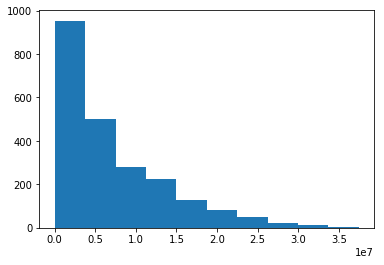

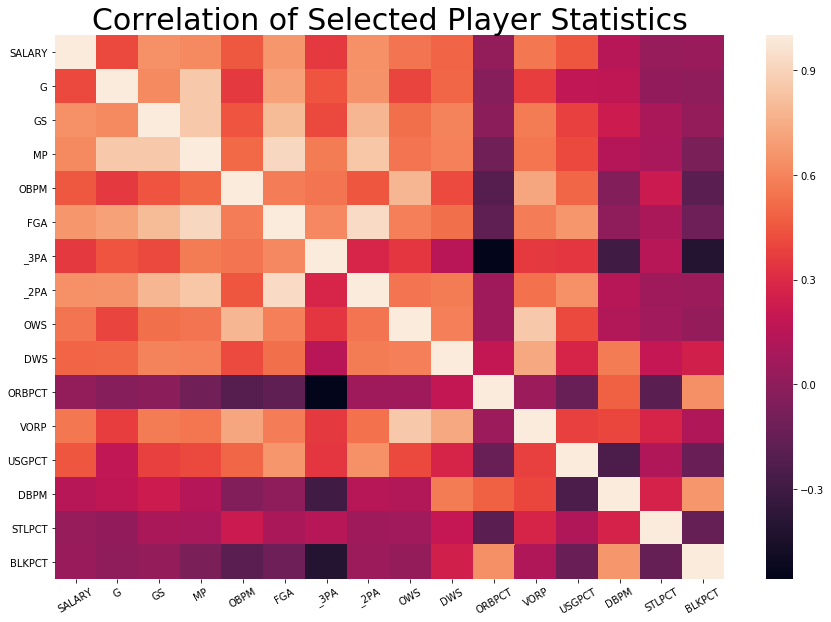

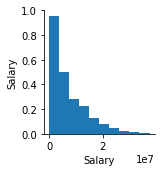

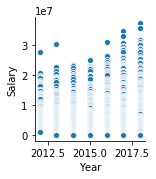

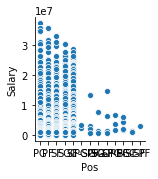

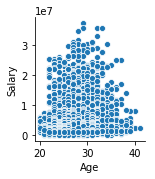

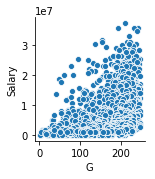

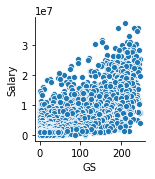

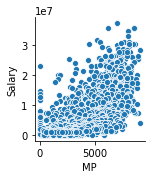

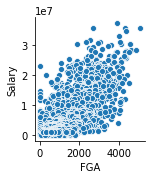

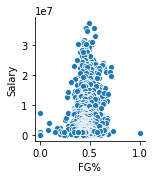

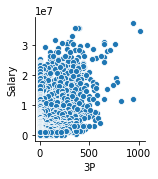

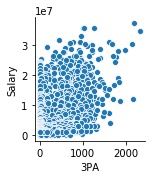

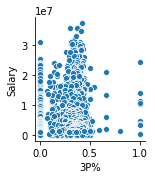

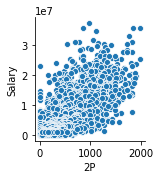

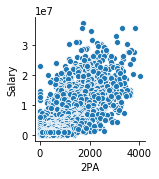

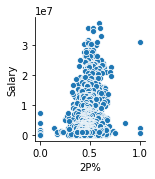

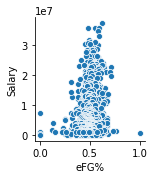

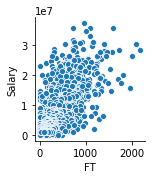

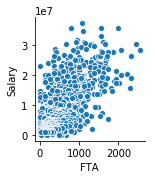

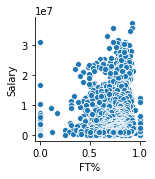

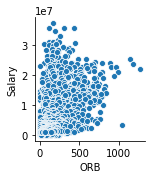

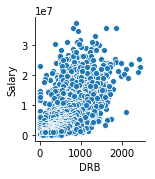

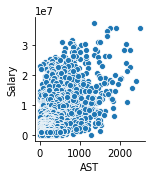

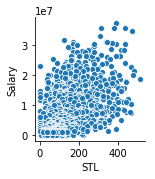

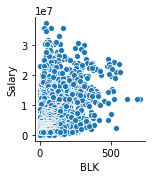

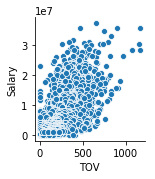

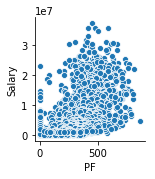

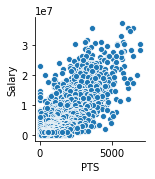

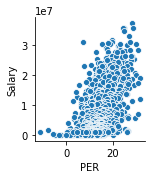

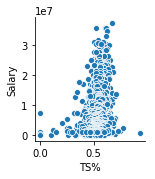

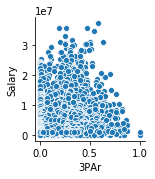

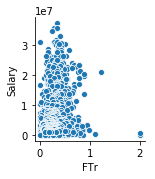

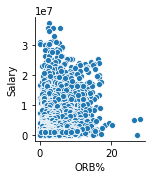

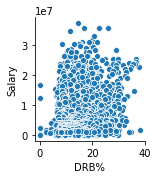

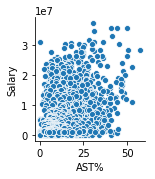

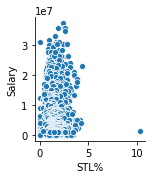

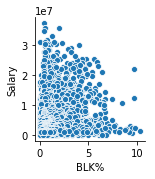

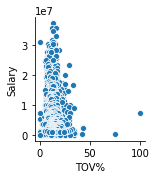

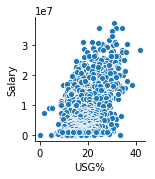

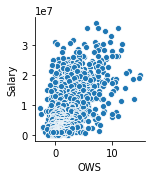

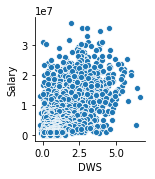

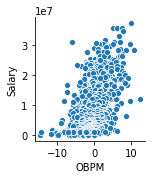

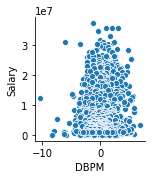

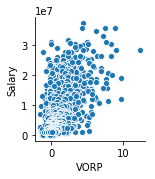

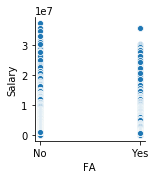

In [24]:
run()

*What did you learn? What relationships do you think will be most helpful as you build your model?*

# Model the Data

## Linear Regression

First I ran linear regression on the 13 features that I selected from looking at the statistics in the exploration part. After doing so, I tried improving the R2 score while not reducing the adjusted R2 for adding more features. This was done by adding square terms and interaction terms between the features. 

Then I went back and looked at some of the features I took out that I thought were useful in adding back. I also tracked to make sure the adjusted R2 did not drop (while R2 goes up). Doing it and then adding additional square and interaction terms, I was able to come up with what I thought was the best model.

## Linear Regression vs. Ridge Regression

With the best model I came up with by linear regression, I decided to implement a Linear vs. Ridge Regression (with scaling). I thought Ridge regularization was better than Lasso because I had already removed needless features and therefore Lasso wouldn't really help with improving the model (Lasso will kill off features that won't help with the model while Ridge will smooth things out.)

This was also the stage in which I implemented Cross-validation. Like in Train-Test split, where I had to group the 2018 stats together in the test set, when doing the CV-train split, I made sure to keep a year's worth of stat as the validation set, and 3 years previous stats data as the training set. This limited how random the CV-train split could be but it also prevented leakage of future knowledge in affecting the model training.

Overall, the Ridge regression showed better in terms of cross validation error mean.

## Minimizing the error by adjusting alpha value

The last step was then to minimize the error by adjusting the alpha value of the ridge regression. I ran cross validation training on alpha values ranging from 0.01 to 100 and found 8.21 to be the optimized alpha value. With that I trained on the whole training set and tested on the test set to come to my final prediction and error.

In [29]:
## %%writefile ../src/models/train_model.py

# imports
import pickle
import pandas as pd
import numpy as np
import itertools

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, KFold,cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

def load_data(filename):
    return pickle.load(open(filename, "rb"))

def save_data(data, filename):
    with open(filename,"wb") as writer:
        pickle.dump(data,writer)

def column_ops(data,columns):
    data2 = data[columns]
    data2.columns = data2.columns.str.replace("%","PCT").str.upper()
    data2.columns = data2.columns.str.replace("2","_2").str.replace("3","_3")
    
    return data2

def add_squares(data,features):
    for fea in features:
        data[fea+"2"] = data[fea]**2
        
    return data

def interactions(data,features):
    for item in itertools.combinations(features,2):
        data[item[0]+item[1]] = data[item[0]]*data[item[1]]
    
    return data

def other_terms(data,original):
    data["_2PA"] = original["2PA"]
    data["_2PA2"] = original["2PA"]**2
    data["FGA"] = original["FGA"]
    data["FGA2"] = data["FGA"]**2
    data["DWS"] = original["DWS"]
    data["DWS2"] = data["DWS"]**2
    data["BLK"] = original["BLK"]
    data["FT"] = original["FT"]
    
    return data
    
def lr_test(dataset, target, itr):
    test = dataset[(dataset.YEAR == 2018)]
    train = dataset[dataset.YEAR != 2018]
    test = test.drop('YEAR', axis=1)
    train = train.drop('YEAR', axis=1)
    
    X_test, y_test = pd.get_dummies(test[test.columns[1:]]), test[target]
    X_train, y_train = pd.get_dummies(train[train.columns[1:]]), np.cbrt(train[target])
    
    # Linear Regression
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    
    r2 = lr.score(X_train, y_train)
    N = X_train.shape[0]
    p = X_train.shape[1]
    
    adjusted_r2 = 1-((1-r2**2)*(N-1)/(N-p-1))
    print(f'Linear Regression R2 score: {r2:.6f}')
    print(f'Adjusted R2 Score: {adjusted_r2: .6f}')
    
    # Predictions
    y_pred = lr.predict(X_test)

    print("\nLR Test Data R2 score: ", r2_score(y_test,y_pred**3))
    print("LR Test MAE: ", mean_absolute_error(y_test,y_pred**3))
    print("Median 2018 NBA Salary: ", y_test.median())
    print("Mean 2018 NBA Salary: ", y_test.mean())
    print("Median predicted Salary: ", np.median(y_pred**3))
    
    plt.figure(figsize=(10,10))
    sns.regplot(y_pred**3, y_test)
    ax = plt.gca()
    locs, labels = plt.xticks()
    ax.set_xticklabels(['0','0','10','20','30','40','50','60','70','80'])
    ax.set_yticklabels(['0','0','20', '40', '60', '80'])
    plt.title("2018 NBA Salary Prediction", size=30)
    plt.xlabel("Prediction Salary (Million $)", size=20)
    plt.ylabel("Actual Salary (Million $)", size=20)
    plt.savefig("../reports/figures/LR_pred_"+str(itr)+".png")
    
    save_data(lr,"../models/lr"+str(itr)+".pickle")
    
    return y_pred, lr

def linear_vs_ridge(dataset):
    
    # Split out the y (keep the Year on both for test/train split)
    X,y = dataset.drop('SALARY',axis=1), dataset[['YEAR','SALARY']]
    
    # Test/Train split
    X,X_test = X[X.YEAR != 2018],X[X.YEAR==2018]
    y,y_test = y[y.YEAR != 2018],y[y.YEAR==2018]
    
    # Drop the Year column on Test data first
    y_test = y_test.drop('YEAR',axis=1)
    X_test = X_test.drop('YEAR',axis=1)
    
    LR_r2s, LM_REG_r2s = [],[]
    LR_MAES, LM_REG_MAES = [],[]
    
    # CV Split
    for i in range(2017,2013,-1):

        years = [i-j for j in range(1,4)]

        X_val,y_val = X[X.YEAR == i], y[y.YEAR == i]
        X_val = X_val.drop('YEAR', axis=1)
        y_val = y_val.drop('YEAR', axis=1)

        X_train, y_train = X[X.YEAR.isin(years)], y[y.YEAR.isin(years)]
        X_train = X_train.drop('YEAR', axis=1)
        y_train = y_train.drop('YEAR', axis=1)
        
        # Set dummies
        X_val,X_test,X_train = pd.get_dummies(X_val), pd.get_dummies(X_test), pd.get_dummies(X_train)

         #simple linear regression
        lm = LinearRegression()
        lm_reg = Ridge(alpha=1)

        lm.fit(X_train, y_train)
        LR_r2s.append(lm.score(X_val, y_val))
        y_pred = lm.predict(X_val)
        LR_MAES.append(mean_absolute_error(y_pred,y_val))

        #ridge with feature scaling
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)

        lm_reg.fit(X_train_scaled, y_train)
        LM_REG_r2s.append(lm_reg.score(X_val_scaled, y_val))
        y_pred_reg = lm_reg.predict(X_val_scaled)
        LM_REG_MAES.append(mean_absolute_error(y_pred_reg,y_val))

    mean_MAE_LR = np.mean(LR_MAES)
    mean_MAE_REG = np.mean(LM_REG_MAES)
    print("Average R2 Score of Linear Regression: ", np.mean(LR_r2s))
    print("Average MAE of Linear Regression: ", mean_MAE_LR)
    print("Average R2 Score of Ridge Regression w/ Scaler: ", np.mean(LM_REG_r2s))
    print("Average MAE of Ridge Regression: ", mean_MAE_REG)
    
    # Test on the whole training set
    y = y.drop('YEAR',axis=1)
    X = X.drop('YEAR',axis=1)
    X = pd.get_dummies(X)
    X_te = scaler.transform(X)
    
    if mean_MAE_REG < mean_MAE_LR:
        print("\nRidge Regression performs better")
        pred = lm_reg.predict(X_te)
    else:
        print("\nLinear Regression performs better")
        pred = lm.predict(X)
    
    print("MAE on the whole training set: ", mean_absolute_error(pred,y))
    
    X_test_te = scaler.transform(X_test)
    pred_test = lm_reg.predict(X_test_te)
    pred_ln = lm.predict(X_test)
    print("MAE on the test set: ", mean_absolute_error(pred_test,y_test))


    return lm_reg, lm, pred_test, y_test

def ridge_alpha_test(dataset):
    
    # Split out the y (keep the Year on both for test/train split)
    X,y = dataset.drop('SALARY',axis=1), dataset[['YEAR','SALARY']]
    
    # Test/Train split
    X,X_test = X[X.YEAR != 2018],X[X.YEAR==2018]
    y,y_test = y[y.YEAR != 2018],y[y.YEAR==2018]
    
    # Drop the Year column on Test data first
    y_test = y_test.drop('YEAR',axis=1)
    X_test = X_test.drop('YEAR',axis=1)
    
    alphalist = 10**(np.linspace(-2,2,200))
    
    err_vec_val = np.zeros(len(alphalist))
    for k,curr_alpha in enumerate(alphalist):
        MAES = []      
        for i in range(2017,2013,-1):
            # Set CV/Train set split
            years = [i-j for j in range(1,4)]
            
            X_val, y_val = X[X.YEAR == i], y[y.YEAR == i]
            X_val = X_val.drop('YEAR', axis=1)
            y_val = y_val.drop('YEAR', axis=1)
            
            X_train, y_train = X[X.YEAR.isin(years)], y[y.YEAR.isin(years)]
            X_train = X_train.drop('YEAR', axis=1)
            y_train = np.cbrt(y_train.drop('YEAR', axis=1))
        
            # Set dummies
            X_val,X_test,X_train = pd.get_dummies(X_val), pd.get_dummies(X_test), pd.get_dummies(X_train)
            values = []
        
            # note the use of a new sklearn utility: Pipeline to pack
            # multiple modeling steps into one fitting process 
            steps = [('standardize', StandardScaler()), 
                     ('ridge', Ridge(alpha = curr_alpha))]

            pipe = Pipeline(steps)
            pipe.fit(X_train.values, y_train)

            val_set_pred = pipe.predict(X_val.values)
            MAES.append(mean_absolute_error(y_val, val_set_pred**3))
        
        err_vec_val[k] = np.mean(MAES)    
    
    min_mae = err_vec_val.min()
    min_alpha = alphalist[np.argmin(err_vec_val)]
    print("Minimum MAE is: ", min_mae)
    print("When alpha is: ", min_alpha)
    
    
    # Retrain on full training set
    X = X.drop('YEAR', axis=1)
    y = y.drop('YEAR', axis=1)

    steps_train = [('standardize', StandardScaler()), 
                     ('ridge', Ridge(alpha = min_alpha))]
    
    pipe_train = Pipeline(steps)
    pipe_train.fit(X.values, np.cbrt(y))
    
    test_pred = pipe_train.predict(X_test.values)
    
    test_mae = mean_absolute_error(y_test, test_pred**3)
    
    print("Test MAE: ", test_mae)
    
    return pipe_train, test_pred, y_test

def run():
    """
    Executes a set of helper functions that read files from data/processed,
    calculates descriptive statistics for the population, and plots charts
    that visualize interesting relationships between features.
    """
    original = ['Salary','Year','G','GS','MP','3P','ORB','AST','TOV','DRB','PTS','VORP','USG%','STL%','DBPM', 'TOV%']
    features = ['G','GS', 'MP','_3P','ORB','AST','TOV','DRB','PTS','VORP','USGPCT','STLPCT','DBPM', 'TOVPCT']
    new = ['_2PA','FGA','DWS','BLK','FT']
    data = load_data('../data/processed/data2.pickle')
    data2 = column_ops(data,original)
    y_pred,lr = lr_test(data2,"SALARY",1)
    data3 = add_squares(data2,features)
    y_pred, lr2 = lr_test(data3,"SALARY",2)
    data4 = interactions(data3,features)
    y_pred, lr3 = lr_test(data4,"SALARY",3)
    data5 = other_terms(data4,data)
    y_pred, lr4 = lr_test(data5,"SALARY",4)
    data6 = interactions(data5,new)
    y_pred, lr5 = lr_test(data6,"SALARY",5)
    data7 = interactions2(data6,features,new)
    y_pred, lr6 = lr_test(data7,"SALARY",6)
    
    lm_reg_cv, lm_cv, pred_test, y_test = linear_vs_ridge(data7)
    lm_reg_cv, test, y_test = ridge_alpha_test(data7)
    
    y_test["PRED"] = test**3
    y_test["Player"] = data[data.Year==2018]["Player"]
    y_test.columns
    y_test["DIFF"] = (y_test.SALARY- y_test.PRED)
    
    plt.figure(figsize=(10,10))
    sns.regplot("PRED","SALARY", data= y_test);
    ax = plt.gca()
    ax.set_xticklabels(['0','0','5','10','15','20','25']);
    ax.set_yticklabels(['0','0','10', '20', '30', '40']);
    ax.tick_params(labelsize=15)
    plt.title("2018 NBA Salary Prediction", size=30);
    plt.xlabel("Prediction Salary (Million $)", size=20);
    plt.ylabel("Actual Salary (Million $)", size=20, fontfamily='sans-serif');
    plt.savefig("../reports/figures/prediction2.png", dpi=400)
    
    plt.figure(figsize=(10,10))
    sns.scatterplot("PRED","DIFF", data= y_test);
    ax = plt.gca()
    ax.set_xticklabels(['0','0','5','10','15','20','25']);
    ax.set_yticklabels(['0','-15','-10', '-5', '0', '5', '10', '15', '20','25']);
    ax.tick_params(labelsize=15)
    plt.title("2018 NBA Salary Prediction Error", size=30);
    plt.xlabel("Prediction Salary (Million $)", size=20);
    plt.ylabel("Pred. Error (Million $)", size=20);
    plt.savefig("../reports/figures/residual.png", dpi=400)


_Write down any thoughts you may have about working with these algorithms on this data. What other ideas do you want to try out as you iterate on this pipeline?_

# Interpret the Model

The Model produced a MAE of 4.4 million \\$, which seems to be bad considering the average salary is 10 million \\$. However throughout modeling this I've realized that there could be many other possible features I can scrape and add to make this model a much better product.

They are:

- Social effects: Popularity of a player determined by twitter mentions, or instagram followers
- Personal effects: player's love for a particular city, their family information, injury history
- Financial effects: NBA contract structure (team, player-wise)